## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

In [1]:
import glob
import pickle
import numpy as np
import cv2
import matplotlib.pyplot as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Why using chessboard images to compute the camera calibration 
The camera reflectred off of a 3D traffic sign and forms a 2D image at a sensor. In math this transformation from 3D object points P(X, Y, Z) to 2D image points P(x, y) is done by a transformative matrix called the camera matrix **Cp** that's needed to calibrate the camera. How to calibration the camera? we can take pictures of known shapes , then We'll be able to detect and correct any distortion errors. Using a chessboard image . A chessboard is great for calibration because it's regular high contrast pattern makes it easy to detect automatically and we know what an undistorted flat chessboard looks like. So we can use the camera to take multiple pictures of a chessboard against a flat surface.Then we'll be able to detect any distortion by looking at the difference between the apparent size and the shape of the squares in these images and the size and shape that they actually are.

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d corners in real world space, object points
imgpoints = [] # 2d corners in image plane, image points

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners that takes image, corner dimensions and corner points
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

Next, Using the **object points** and **image points** to calibrate this camera.

## 2. Compute the camera calibration matrix and distortion coefficients given a set of object points and image points
Light rays often bend a little too much or too little at the edges of a curved lens of a camera.So there are 2 Distortion types:
- Radial Distortion
- Tangential Distortion

The distortion can generally be captured by Distortion coefficients = (k1, k2, p1, p2, k3), Those values reflect the amount of radial and tangential distortion in an image. So these coefficients can calibrate the camera and undistort the images. 

**Radial distortion correction**
$$x_{distorted} = x_{idea]}(1 + k_{[1]}r^{2} + k_{2}r^{4} + k_{3}r^{6})$$
$$y_{distorted} = y_{idea]}(1 + k_{[1]}r^{2} + k_{2}r^{4} + k_{3}r^{6})$$

**tangential distortion correction**
$$x_{corrected} = x + [2p_{1}xy + p_{2}(r^{2} + 2x^{2})]$$
$$y_{corrected} = y + [p_{1}(r^{2} + 2y^{2}) + 2p_{2}xy]$$

In [3]:
def cal_undistort(img, objpoints, imgpoints):
    img_size = (test_img.shape[1], test_img.shape[0])
    
    # Given object points and image points, get calibration matrix and distortion coefficients
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    
    # Correcting for distortion
    undst_img = cv2.undistort(test_img, mtx, dist, None, mtx)
    
    # Save undistortion image
    cv2.imwrite('output_images/undistorted_image.jpg', undst_img)
    
    # Save the camera calibration result calibration matrix and distortion coefficients
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump(dist_pickle, open('output_images/result_dist_mtx_pickle.p', "wb"))
    
    return undst_img

## 3. Apply a distortion correction to raw image

Text(0.5, 1.0, 'Undistorted Image')

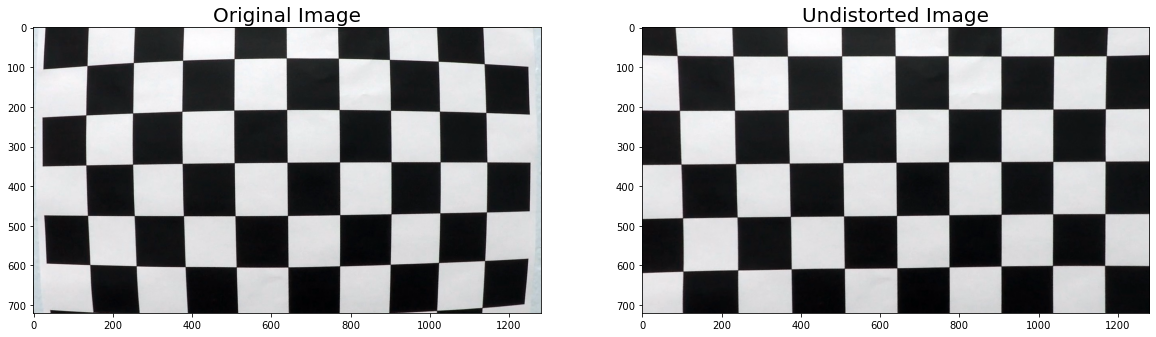

In [4]:
test_img = cv2.imread('camera_cal/calibration1.jpg')

undistorted = cal_undistort(test_img, objpoints, imgpoints)

# Visualize camera calibration result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize = 20)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize = 20)

## 4. Use color transforms, gradients to create a thresholded binary image.

#### Color transforms 
 A color space is a specific organization of colors, color spaces provide a way to categorize colors and represent them in digital images. RGB is red-green-blue color space. 
 
 <img src="images/rgb.png" style="width:300px;height:300px;">
 
 However RGB Thresholding doesn't work that well in images that include varying light conditions like the lane under extreme brightness or when lanes are a different color like yellow. These are some of the most commonly used color spaces in image analysis. HLS Color Space, This isolates the lightness or L component of each pixel in an image. And this is the component that varies the most under different lighting conditions.But the H and S channels stay fairly consistent under shadow or excessive brightness. So discard the information in the L channel, we should be able to detect different colors of lane lines more reliable than in RGB color space. 
 
 <img src="images/hls.png" style="width:600px;height:300px;">
 
H has a range from 0 to 179 for degrees around the cylindrical color space

https://docs.opencv.org/master/de/d25/imgproc_color_conversions.html

In [5]:
# Convert to HLS color space and separate the Saturation channel
def hls_select(img, thresh=(0,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

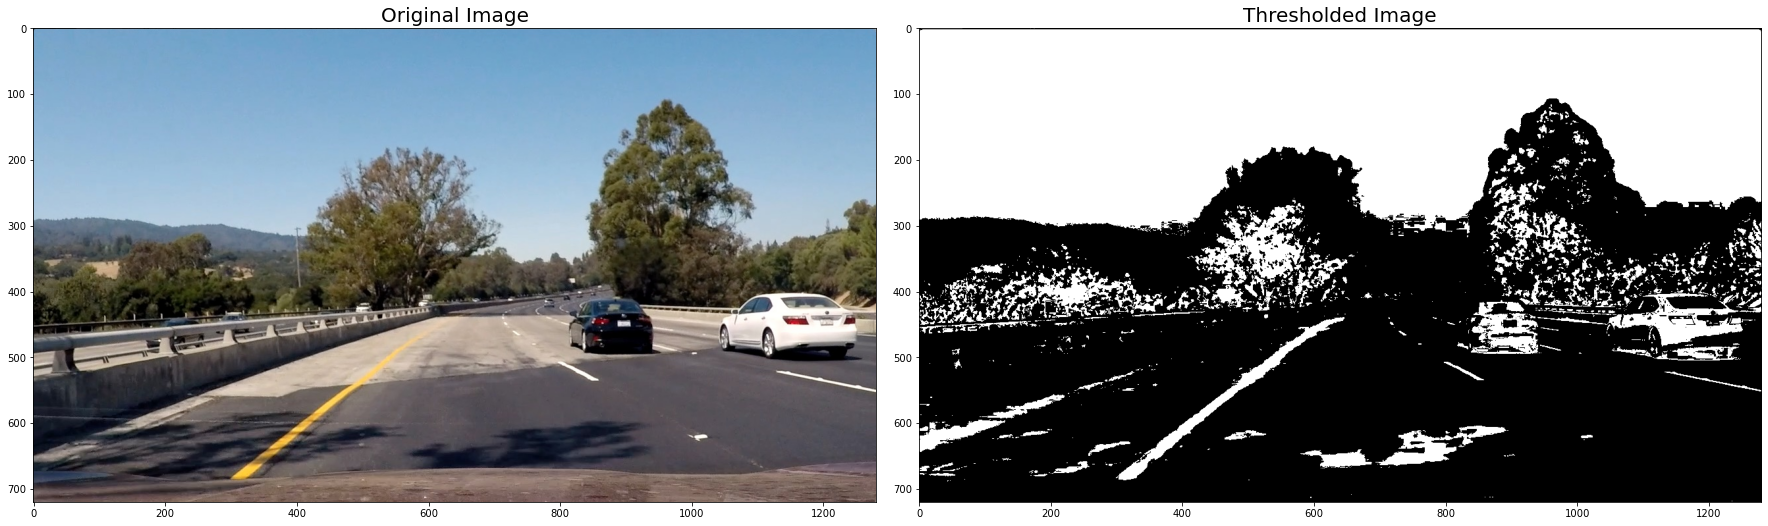

In [6]:
img = cv2.imread('test_images/test4.jpg')

hls_binary = hls_select(img, thresh=(90,255))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(hls_binary, cmap='gray')
ax2.set_title('Thresholded Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Sobel Operator
Sobel operator is a way fo taking the derivative of the image in the x or y direction. 

$$gradient = ∑ (region * S_{x})$$

The operators for Sobelx and Sobely:

$$ S_{x} = \begin{bmatrix}
    -1  & 0  & 1\\
    -2  & 0 & 2 \\
    -1 & 0 & 1 
\end{bmatrix}\;\;\; S_{y} = \begin{bmatrix}
    -1  & -2  & -1\\
    0  & 0 & 0 \\
    1  & 2 & 1 
\end{bmatrix} \;\;\; $$


<img src="images/sobel_operator.gif" style="width:200;height:200;"> 

Taking the gradient in the x direction emphasizes edges closer to vertical, the y direction emphasizes edges closer to horizontal.

In [7]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    if orient == 'x':
        abs_soebl = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_soebl = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_soebl/np.max(abs_soebl))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return binary_output

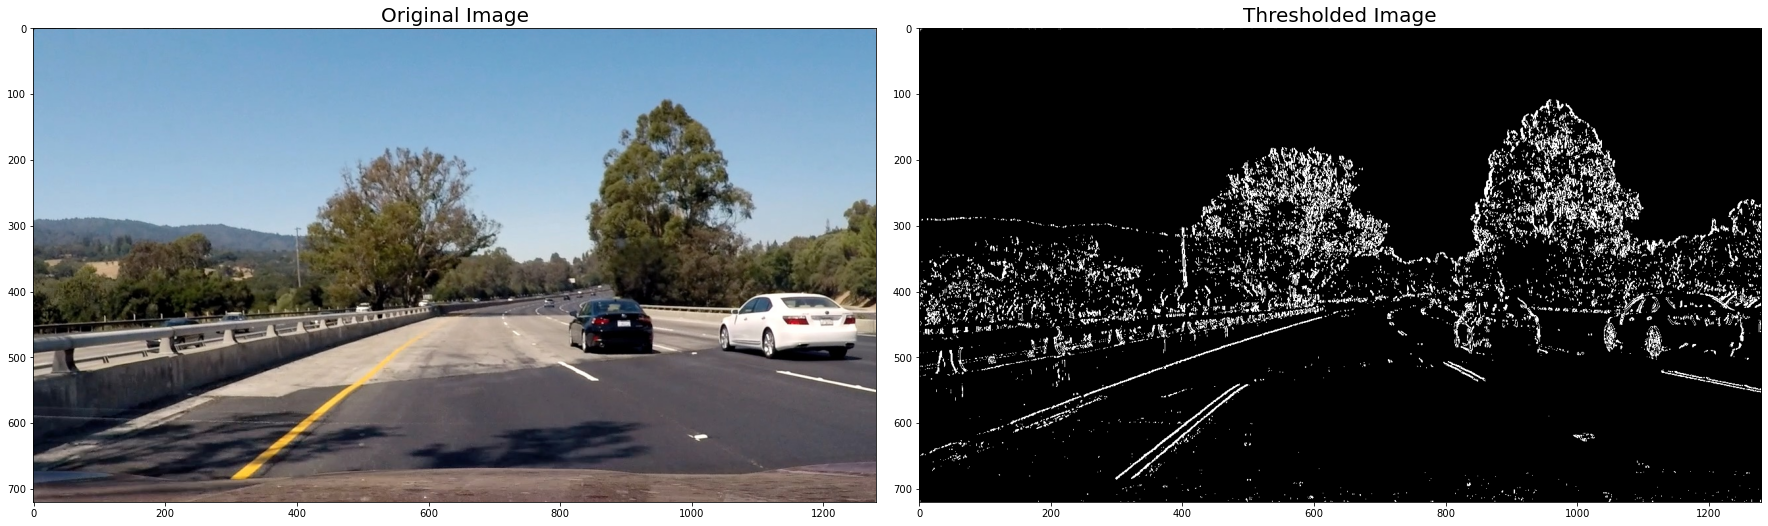

In [8]:
grad_binary = abs_sobel_thresh(img, orient='x', thresh=(20, 100))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Magnitude of the Gradient

$$abs\_sobel_{xy} = \sqrt{(sobel_{x})^{2} + (sobel_{y})^{2}}$$

In [9]:
# Calculate the magnitude of the gradient 
def mag_threshold(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

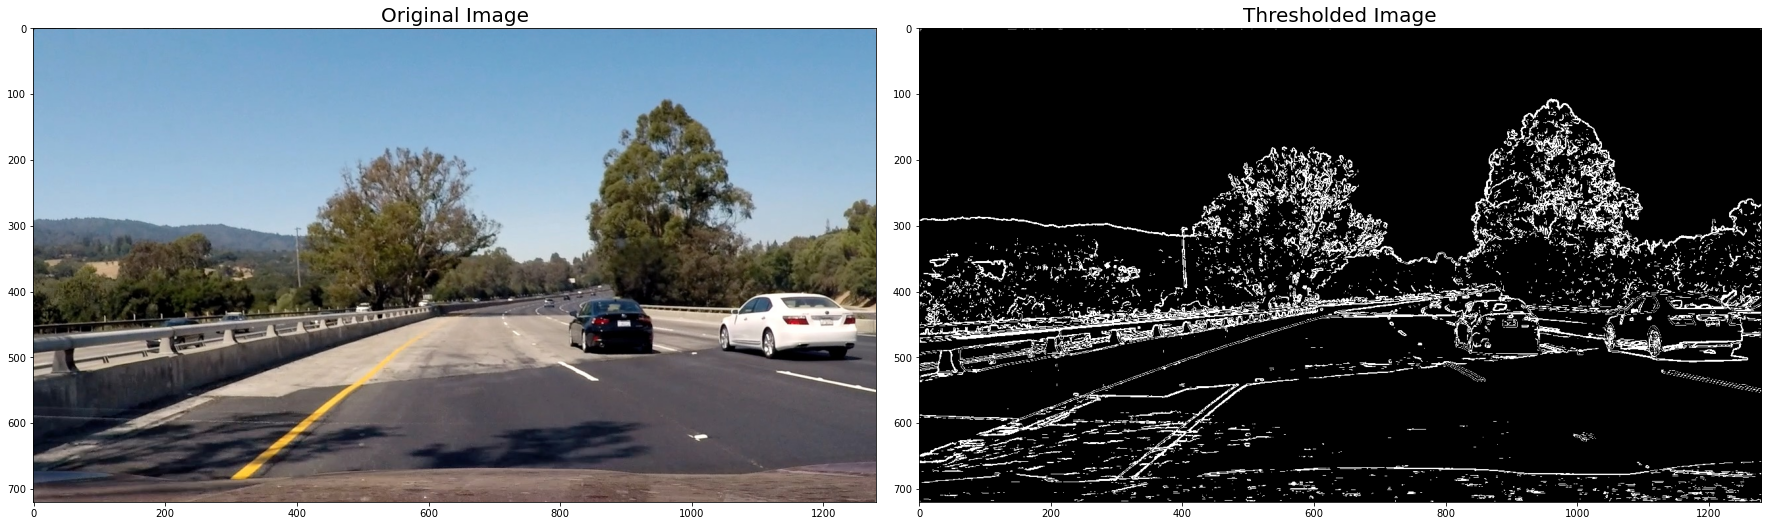

In [10]:
mag_binary = mag_threshold(img, sobel_kernel=3, mag_thresh=(30, 100))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Direction of the Gradient
In the case of lane lines, we're interested only in edges of particular orientation. The direction of the gradient is simply the inverse tangent(arctangent) of the y gradient divided by the x gradient:

$$arctan(sobel_{y}/sobel_{x})$$

In [11]:
def dir_threshold(img, sobel_kernel=3, dir_thresh=(0, np.pi/2)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the gradient direciton
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1
    
    return binary_output

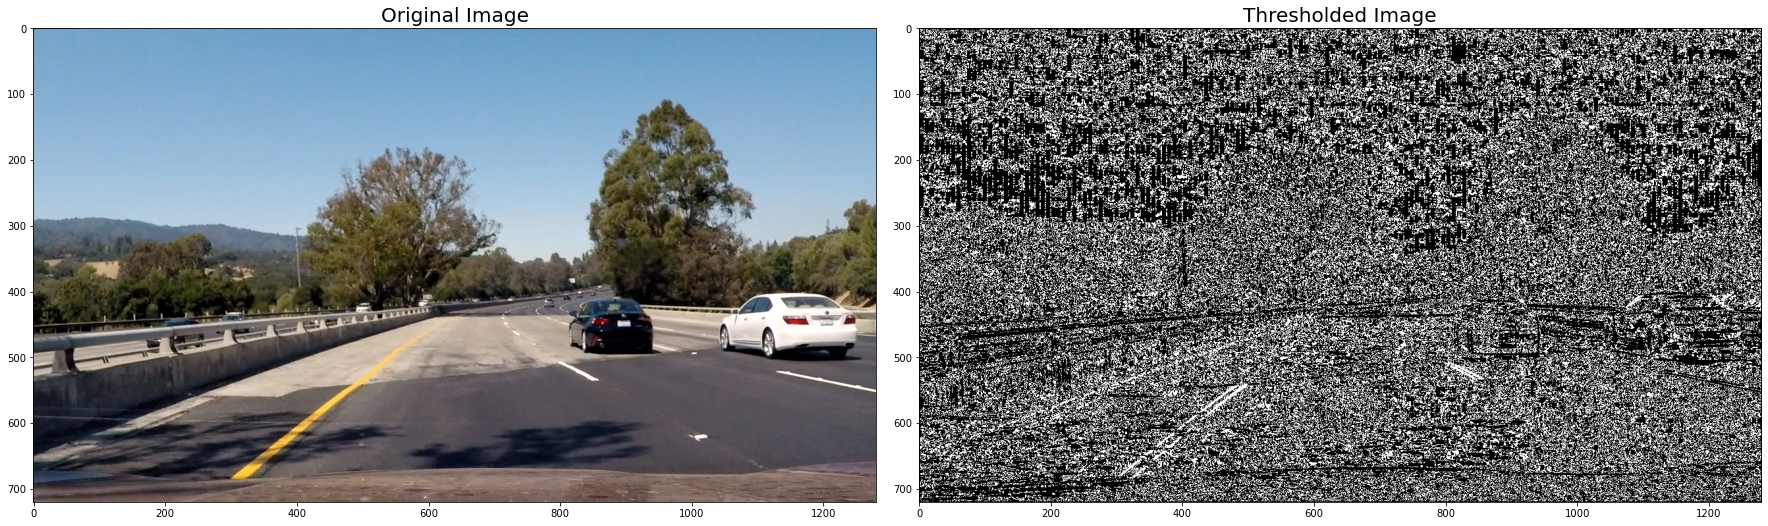

In [12]:
dir_binary = dir_threshold(img, sobel_kernel=3, dir_thresh=(0.7, 1.3))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Combining color transforms, gradients thresholds

In [88]:
def pipeline(img, kernel=3, s_thresh=(170, 255), g_thresh=(20, 100), m_thresh=(30, 100),d_thresh=(0.7, 1.3)):
    
    # Convert to HLS color space and separate the Saturation channel
    hls_binary = hls_select(img, thresh=s_thresh)
    
    # Calculate the x and y gradient
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel = kernel, thresh = g_thresh)
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel = kernel, thresh = g_thresh)

    # Calculate the magnitude of the gradient
    mag_binary = mag_threshold(img, sobel_kernel=kernel, mag_thresh=m_thresh)

    # Calculate direction
    dir_binary = dir_threshold(img, sobel_kernel=kernel, dir_thresh=d_thresh)
    
    # Combine thresholds
    combined = np.zeros_like(dir_binary)
    combined[(hls_binary==1) & ((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    # Save result 
    cv2.imwrite('output_images/binary_combo_example.jpg', np.dstack((combined,combined,combined))*255)

    
    return combined

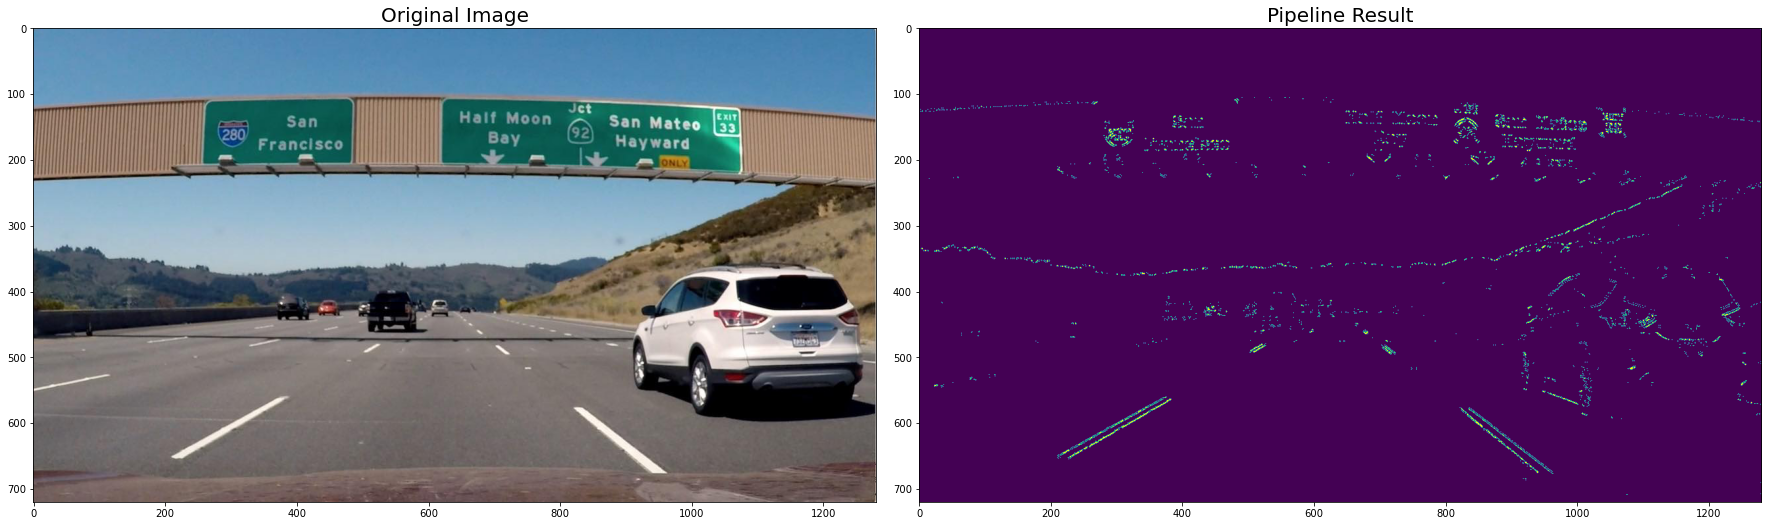

In [90]:
img = cv2.imread('test_images/signs_vehicles_xygrad.png')

result = pipeline(img, s_thresh=(100, 255), g_thresh=(20, 100), m_thresh=(60, 100),d_thresh=(0.7, 1.3))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 4. Apply a perspective transform to rectify binary image ("birds-eye view")

## 5. Detect lane pixels and fit to find the lane boundary

## 6. Determine the curvature of the lane and vehicle position with respect to center

## 7. Warp the detected lane boundaries back onto the original image

## 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position